pdfplumber를 사용해 test해본 notebook

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
import cv2
from pathlib import Path
from tqdm import tqdm
import math
import pdfplumber
import pytesseract as pyt
import tempfile
from ksatparser.utils import pdf2pngs
%matplotlib inline

In [3]:
test_name = "2018_9"
pdf_dir = Path("pdf/problem/")
pdf_path = pdf_dir/(test_name+".pdf")

imgs = pdf2pngs(pdf_path)

# edge detection

In [6]:
def imshow(img):
    fig, ax= plt.subplots(1,1, figsize=(20,20))
    ax.imshow(img, cmap = "gray")

(3309, 2339, 3)


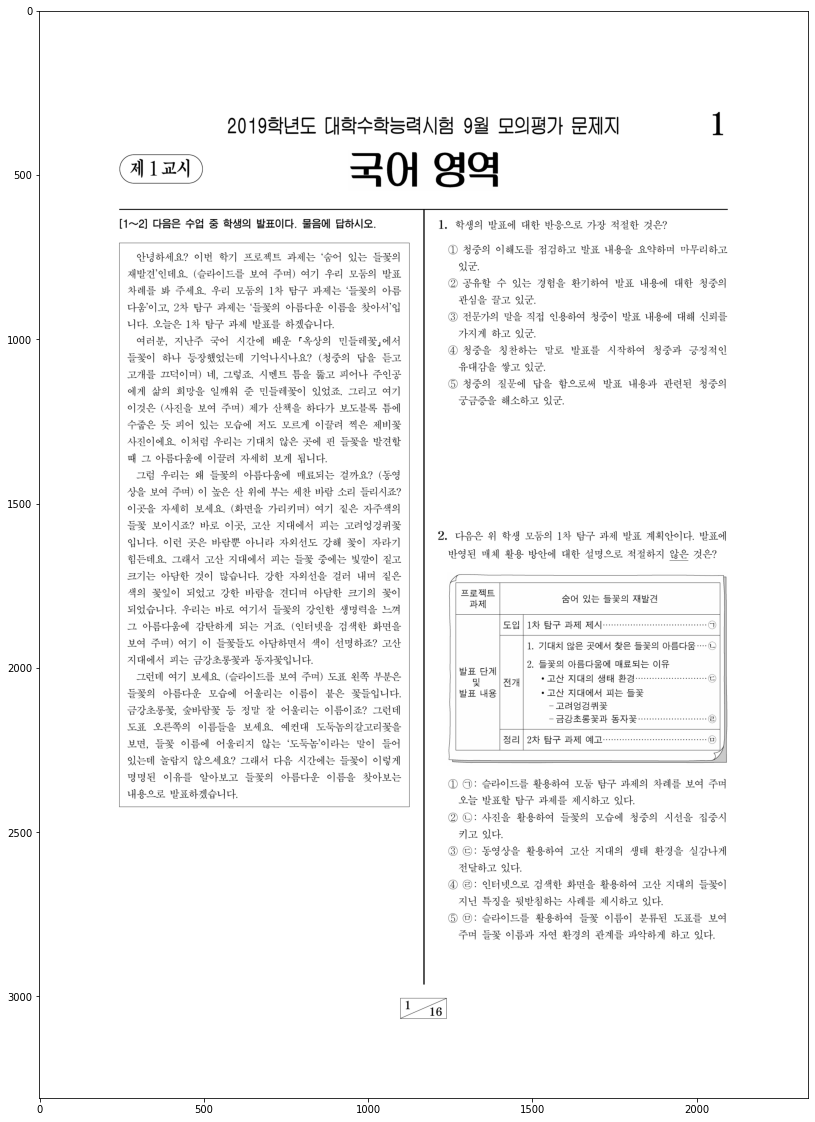

In [42]:
# Load the image
img = cv2.cvtColor(imgs[0], cv2.COLOR_GRAY2BGR)
gray = img
print(img.shape)
imshow(gray)

In [43]:
thresh1 = 1300
thresh2 = 400
dst = cv2.Canny(gray, thresh1, thresh2)
# canny 조정 참고
# https://engineer-mole.tistory.com/243

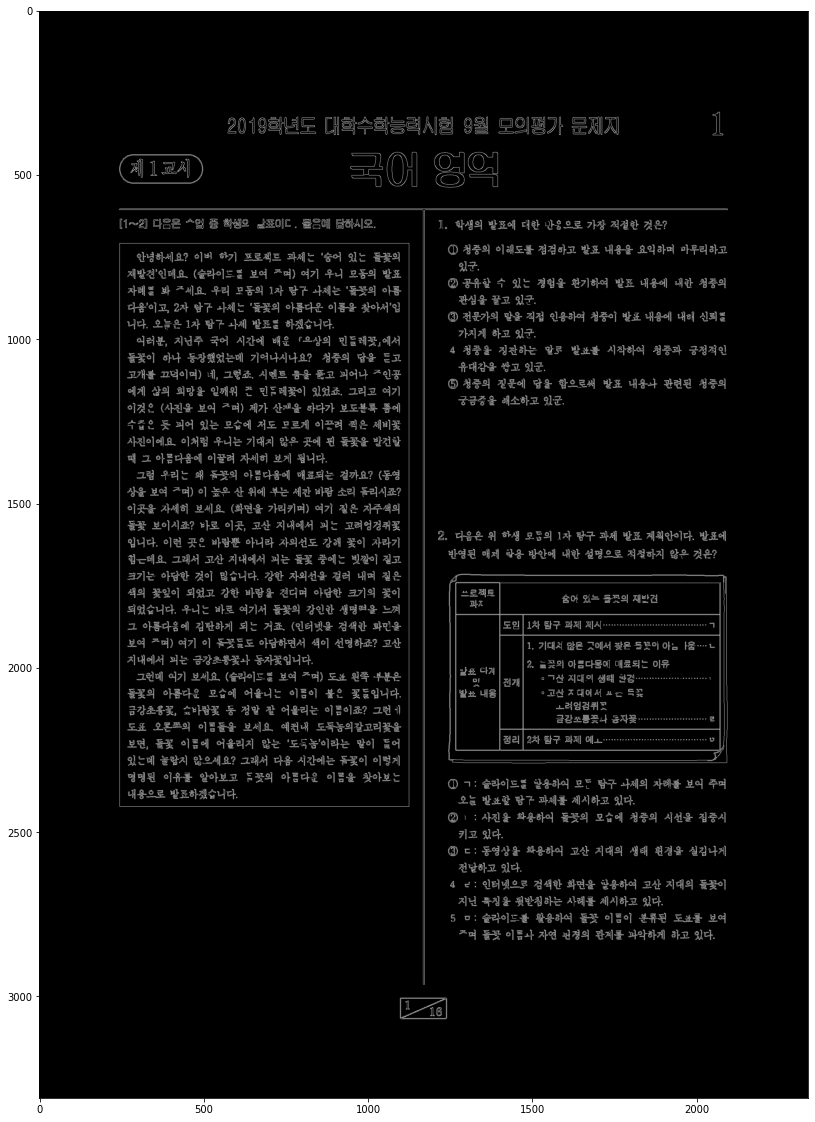

In [44]:
imshow(dst)

In [45]:
# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

# problematic hough
lines = cv2.HoughLinesP(dst, 1, np.pi / 180, 1000, None, 1000, 10)

# extract T lines function
def extract_T(lines):
    '''
    arguments : list([x1,y1,x2,y2])
    return : (max length horizontal line, max length vertical line)
    '''
    xlen = []
    ylen = []
    maxx = 0
    maxy = 0
    for i, line in enumerate(lines):
        x1,y1,x2,y2 = line[0]
        xlen.append(abs(x2-x1))
        ylen.append(abs(y2-y1))
    xi = xlen.index(max(xlen))
    yi = ylen.index(max(ylen))
    return lines[yi], lines[xi]

T = extract_T(lines)

l = T[0][0]
cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

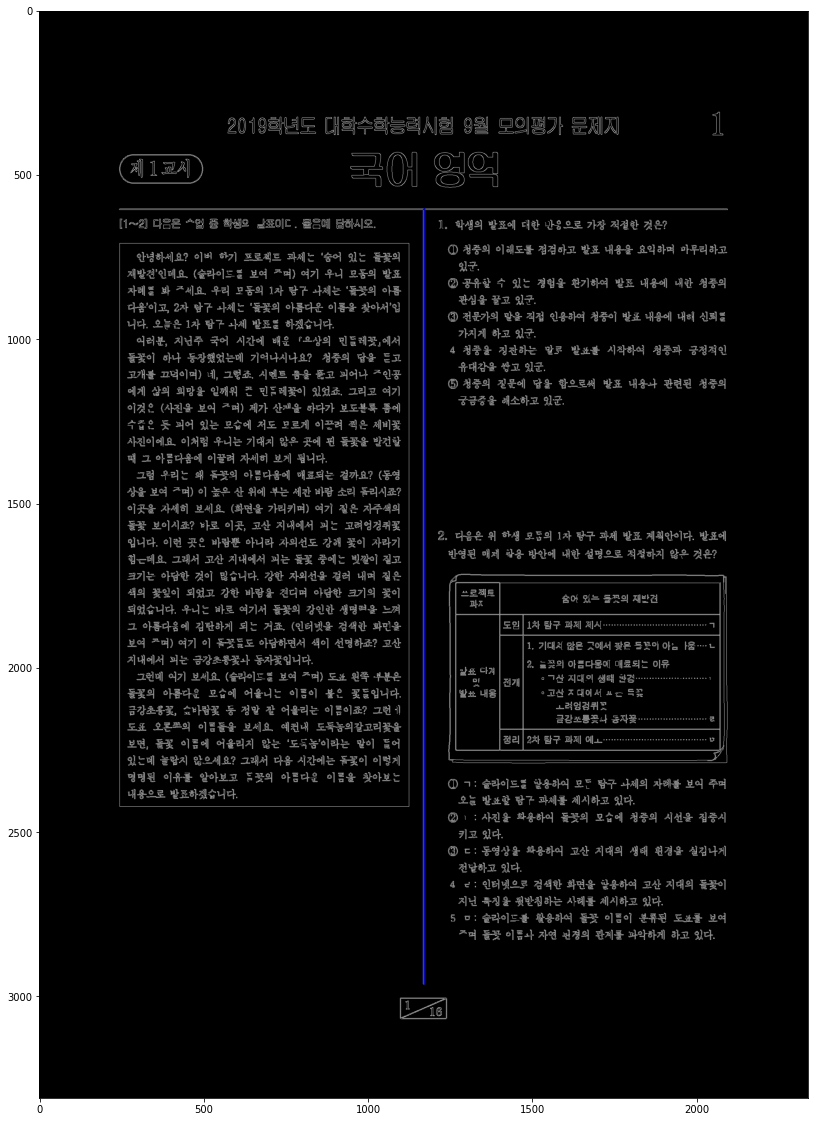

In [39]:
imshow(cdst)

In [731]:
T

(array([[1170, 2964, 1170,  604]], dtype=int32),
 array([[ 243,  607, 2095,  607]], dtype=int32))

In [732]:
x1,y1,_,y0 = T[0][0]
if y0>y1:
    y0,y1 = y1,y0
x0,_,x2,_ = T[1][0]
x0 -= 15
x2 += 15
y0 += 3
y1 += 5

In [733]:
dst.shape

(3309, 2339)

In [734]:
left = gray[y0:y1,x0:x1-5]
right = gray[y0:y1,x1+5:x2]

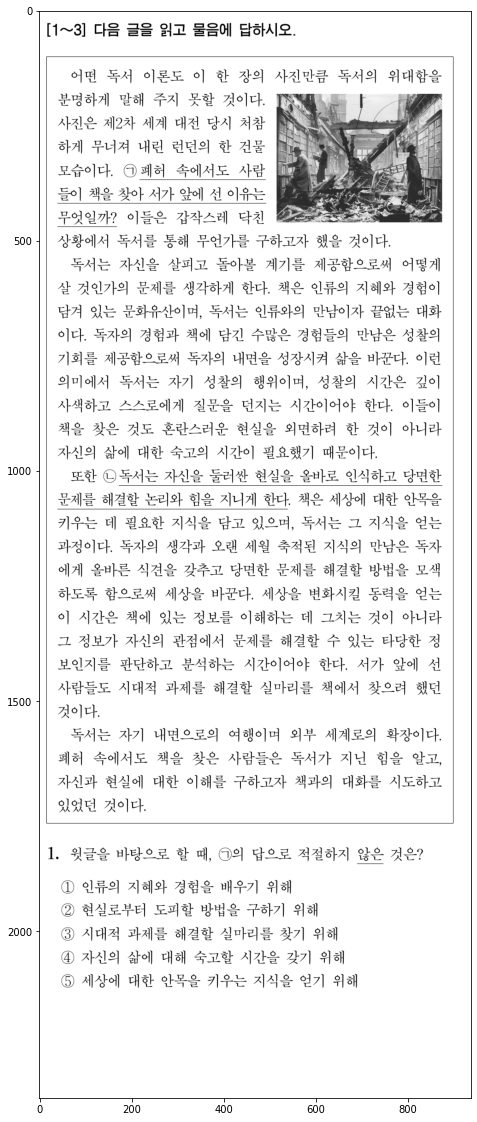

In [735]:
imshow(left)

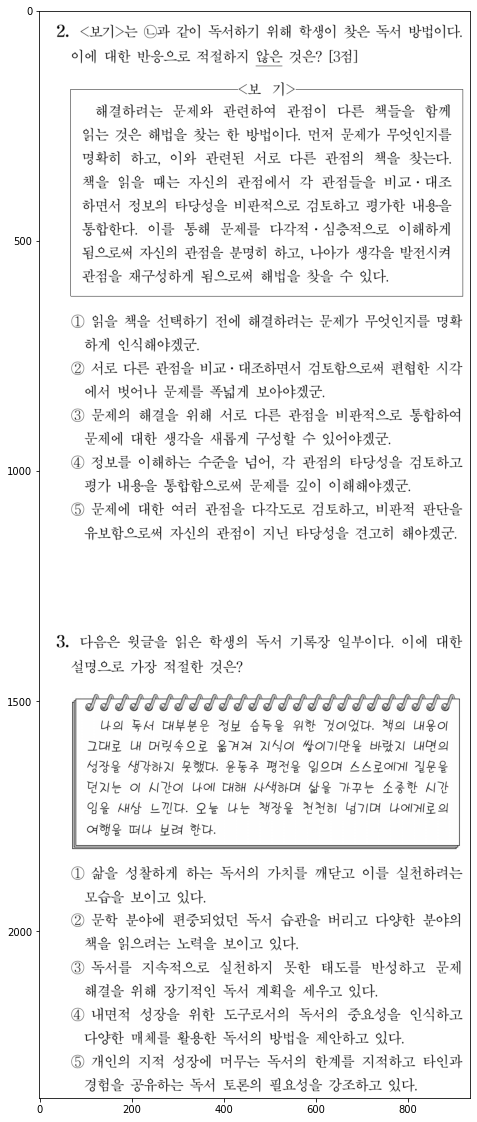

In [736]:
imshow(right)

In [737]:
# pre-processing
_, thresh = cv2.threshold(left, 220, 255, cv2.THRESH_BINARY)
thresh = cv2.bitwise_not(thresh)

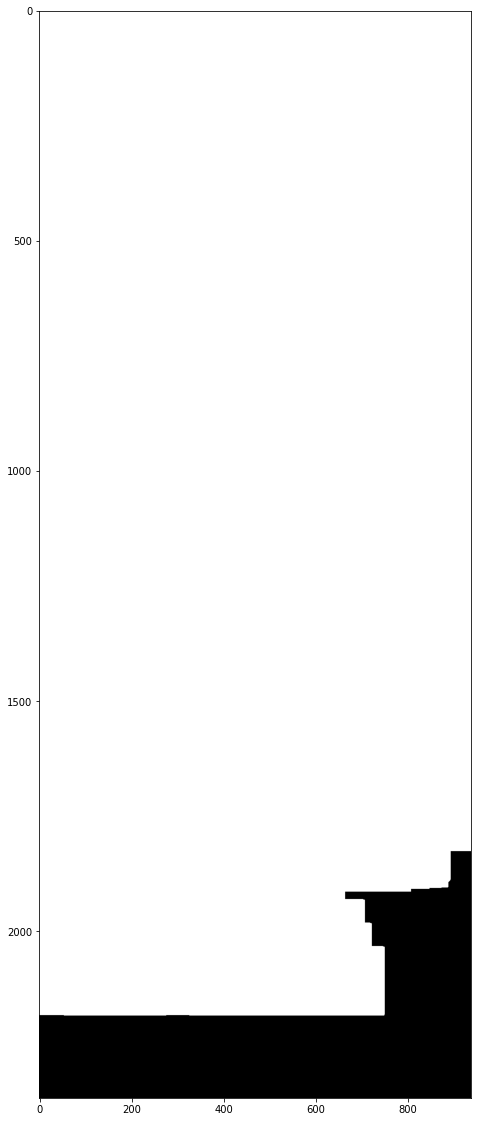

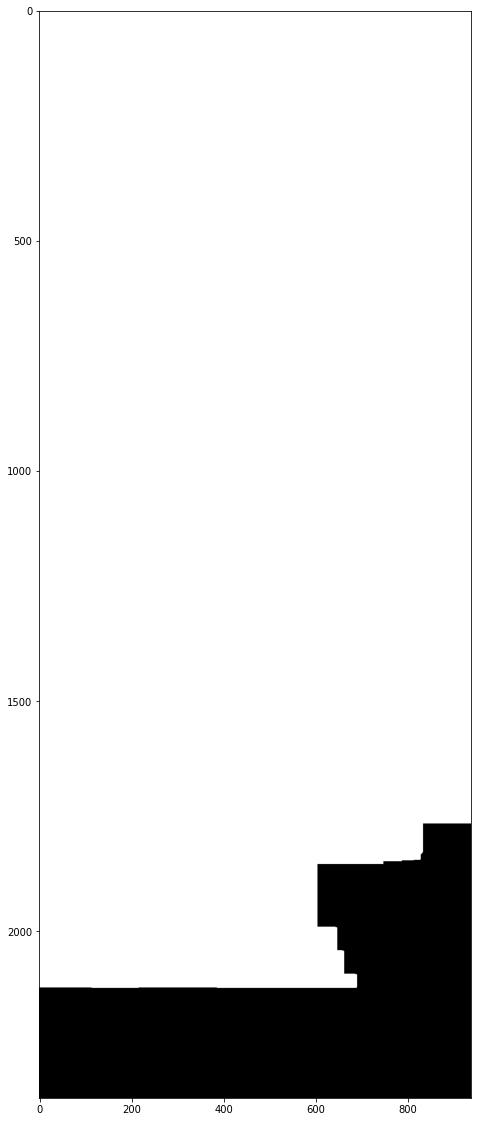

In [738]:
kernel = np.ones((25, 25))
iterations = 5

thresh = cv2.dilate(thresh, kernel, iterations=iterations)
imshow(thresh)
thresh = cv2.erode(thresh, kernel, iterations=iterations)
imshow(thresh)

In [739]:
# find the contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# sort y-axis
contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[1])
print(len(contours))

1


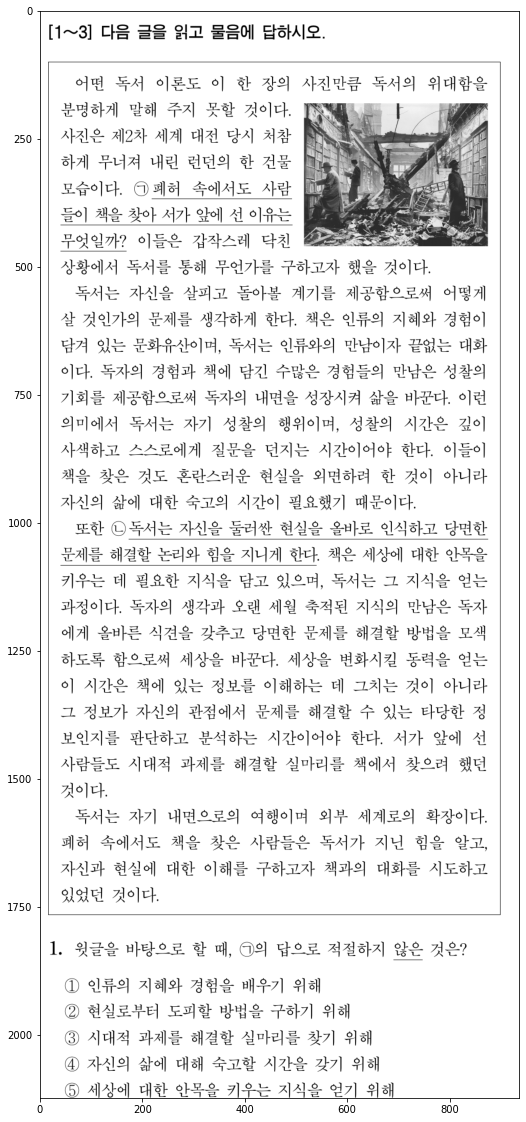

In [740]:
for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    # if w > cfg.min_width and h > cfg.min_height:
    imshow(left[y : y + h, x : x + w])

## template matching - 물음에 답하시오

In [741]:
template = cv2.imread(str(data_dir/"template"/"moorm.png"))

In [742]:
type(template)

numpy.ndarray

In [743]:
 res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)

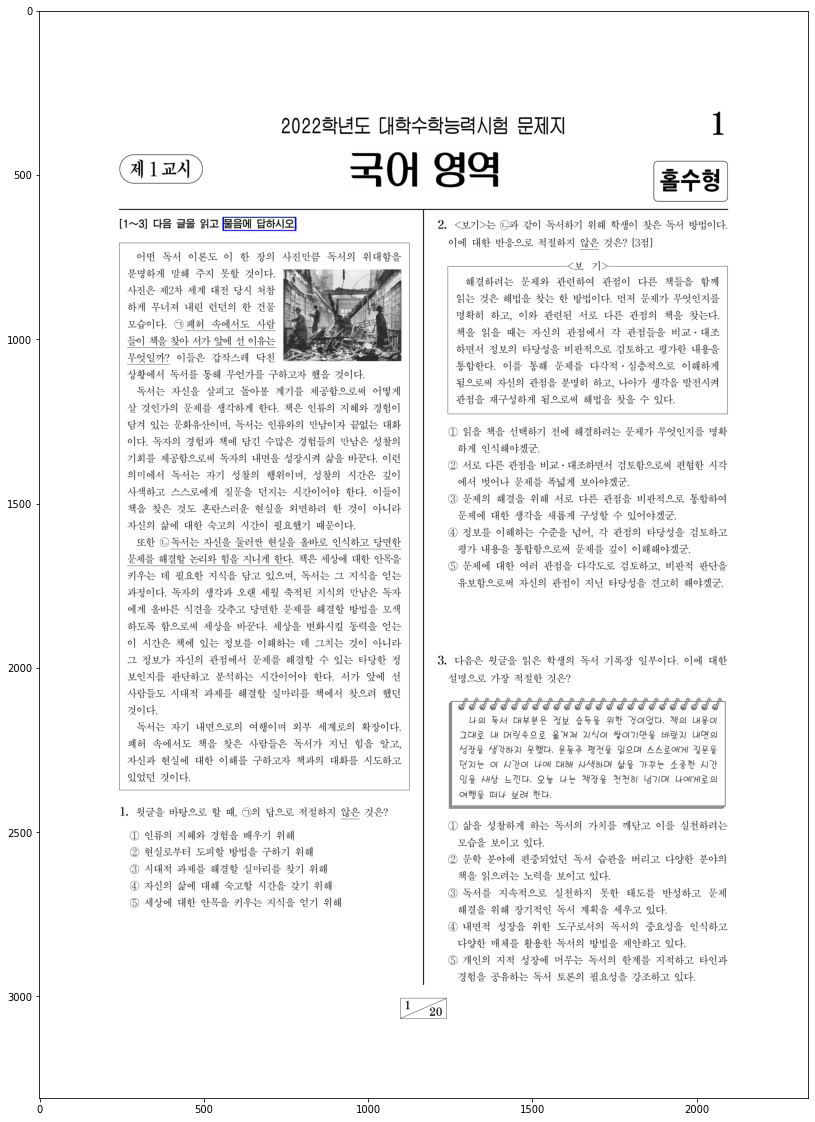

In [744]:
cimg = img.copy()
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(cimg, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (0,0,255), 2)
imshow(cimg)

## pdf plumber

In [47]:
def get_xy(word, width, height):
    x0 = word['x0'] / width
    y0 = word['top'] / height
    x1 = word['x1'] / width
    y1 = word['bottom'] / height
    return x0,y0,x1,y1
    


def find_problems(words):
    probs = []
    for w in words:
        if w['text'][-1]=='.' and w['text'][:-1].isdigit():
            probs.append(w)
    return probs


def find_jimoons(words):
    jimoons = []
    for word in words:
        if word["text"][0] == '[' and word["text"][-1] == ']' and '～' in word['text']:
            jimoons.append(word)
    return jimoons

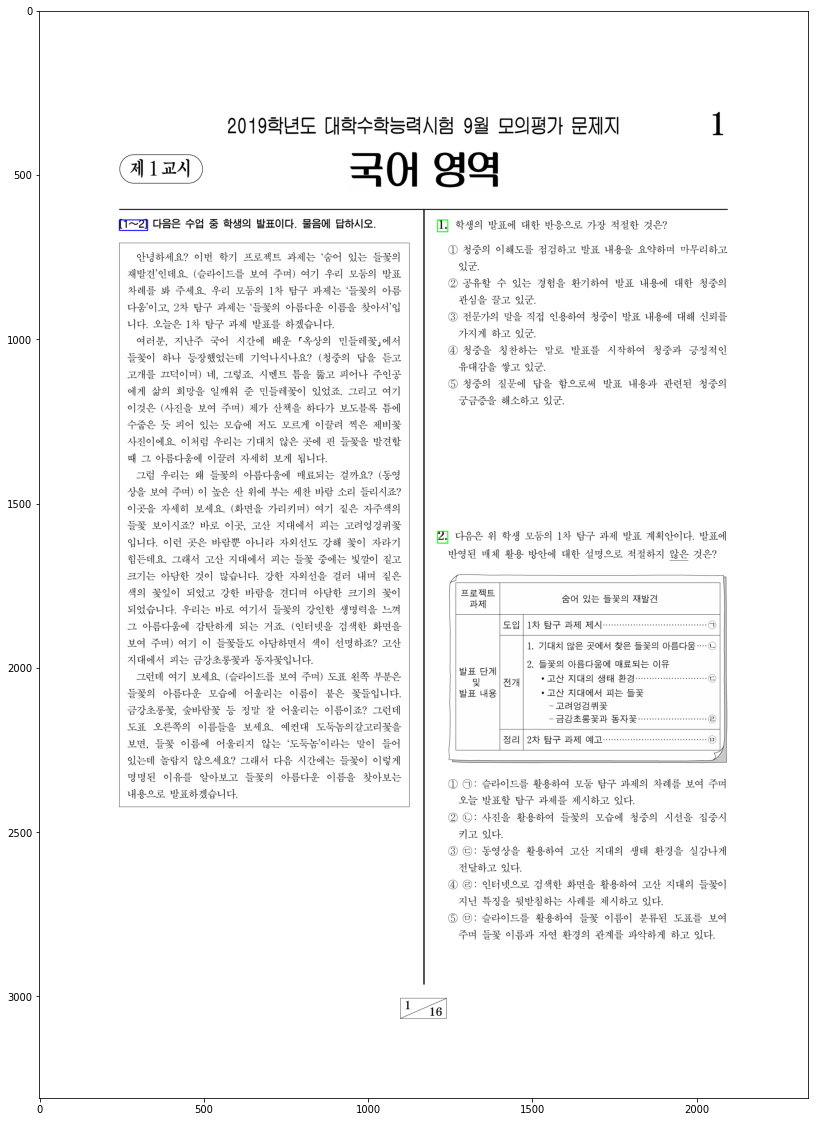

In [48]:
# check 
cimg = img.copy()
h,w,_ = cimg.shape
with pdfplumber.open(str(pdf_path)) as pdf:
    first_page = pdf.pages[0]
    words = first_page.extract_words()
    
    # jimoon
    jimoon = find_jimoons(words)[0]
    x0,y0,x1,y1 = get_xy(jimoon, first_page.width, first_page.height)
    x0,y0,x1,y1 = int(x0*w), int(y0*h), int(x1*w), int(y1*h)
    cv2.rectangle(cimg, (x0,y0), (x1,y1), (0,0,255), 2)
    
    # problem
    probs = find_problems(words)
    for p in probs:
        x0,y0,x1,y1 = get_xy(p, first_page.width, first_page.height)
        x0,y0,x1,y1 = int(x0*w), int(y0*h), int(x1*w), int(y1*h)
        cv2.rectangle(cimg, (x0,y0), (x1,y1), (0,255,0), 2)
    imshow(cimg)